In [2]:
# Z == solar units

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as cm
import pynbody
from michaels_functions import center_and_r_vir, remove_bulk_velocity
from matplotlib.colors import LogNorm
from matplotlib.pyplot import figure
from matplotlib.lines import Line2D

In [2]:
# %%time
path = "bulk1/data_2/hydro_59/output/"
data = pynbody.load(path + "output_00050")
aexp = data.properties['a']
data.physical_units()
r_vir = center_and_r_vir(data, aexp, path)
remove_bulk_velocity(data)
r_e = 0.1 * r_vir
sph_5 = pynbody.filt.Sphere(radius = '5.0 kpc') # %(r_e*1.4))
region = data[sph_5]
rho = region.gas["rho"].in_units("m_p cm**-3")
f = open(data.filename + "/info_"+data.filename[-5:]+".txt","r")
lines = f.readlines()
f.close()
for line in lines:
    if line[0:13]=="unit_l      =":
        print line[:-1]
        unit_l = float(line[14:-1])
    if line[0:13]=="unit_d      =":
        print line[:-1]
        unit_d = float(line[14:-1])
    if line[0:13]=="unit_t      =":
        print line[:-1]
        unit_t = float(line[14:-1])
    if line[0:13]=="omega_b     =":
        print line[:-1]
        omega_b = float(line[14:-1])

('shifting on Stars:', SimArray([ 0.00308878, -0.03302971, -0.04676732], 'kpc'))
('virial radius:', SimArray(152.40432611, 'kpc'))
omega_b     =  0.450000017881393E-01
unit_l      =  0.682025380323961E+26
unit_d      =  0.123367583719985E-28
unit_t      =  0.163687521954501E+18


In [3]:
%%time
m_p = pynbody.array.SimArray(1.672621777e-24, "g")
K_b = pynbody.array.SimArray(1.38064852e-16, "cm**2 g s**-2 K**-1")
G = pynbody.array.SimArray(6.67259e-8, "cm**3 g**-1 s**-2")
T_mean = pynbody.array.SimArray(10., "K")
dummy_length = pynbody.array.SimArray(1., "cm")
dummy_mass = pynbody.array.SimArray(1., "g")
turb = np.sqrt( region.g["turb"] * 2./3. ) * unit_l / unit_t / 1e5
turb = pynbody.array.SimArray(turb*1e5, units = "cm s**-1")
#T = region.g["temp"]
#c_s = np.sqrt(K_b * T_mean / m_p)

CPU times: user 40.7 ms, sys: 4.59 ms, total: 45.3 ms
Wall time: 43.4 ms


In [4]:
def make_pdf(s, s_bar, sigma_s):
    pdf = (1/np.sqrt(2*np.pi*(sigma_s**2))) * (np.exp(-0.5*(((s - s_bar)/sigma_s)**2)))
    return pdf

def calc_integral(s, pdf, X_H2, ds):
    integ = 0.0
    integ = np.sum(np.exp(s)*pdf*X_H2*ds)
    return integ

def calc_integral2(s, pdf, X_CO, ds):
    integ = 0.0
    integ = np.sum(np.exp(s)*pdf*X_CO*ds)
    return integ

def calc_lambda_jeans(n_H, K_b, T, m_p):
    lambda_jeans = (np.sqrt(K_b * T / m_p) / np.sqrt(4* np.pi * G * n_H * m_p))
    return lambda_jeans

def calc_n_LW(n_H, G_o, lambda_jeans, Z):
    kappa = 1000 * m_p * Z
    rad_field_outside = G_o #in solar units
    exp_tau = np.exp(-kappa * n_H * lambda_jeans)
    n_LW = rad_field_outside * exp_tau
    return n_LW

def calc_n_LW_ss(n_H, n_H2, G_o, lambda_jeans):
    kappa = 1000 * m_p * Z
    rad_field_outside = G_o #in solar units
    exp_tau = np.exp(-kappa * n_H * lambda_jeans)
    N_H2 = n_H2*lambda_jeans
    #N_H2 = N_H2.in_units('1')
    term1 = pynbody.array.SimArray((0.965/((1+(N_H2/5e14))**2)), "1")
    term2 = ( (0.035/np.sqrt(1+(N_H2/5e14))) * np.exp(-1*np.sqrt(1+(N_H2/5e14))/1180) )
    #term1 = term1.in_units('1')
    #term2 = term2.in_units('1')
    S_H2 = term1 + term2
    n_LW_ss = rad_field_outside * exp_tau * S_H2
    return n_LW_ss

def calc_X_H2(n_H, Z, n_LW):
    DC = 1.7e-11
    CC = 2.5e-17            #cm3 s-1
    numerator = DC * n_LW
    denominator = CC * Z * n_H
    X_H2 = 1 / (2 + (numerator/denominator) )
    return 2*X_H2

def self_shielding_iterations(n_H, G_o, lambda_jeans, Z):
    X_H2 = np.zeros(100)
    n_LW = np.zeros(100)
    n_H2 = np.zeros(100)
    n_LW_ss = np.zeros(100)
    S_H2_ss = np.zeros(100)
    N_H2_ss = np.zeros(100)
    X_H2_ss = np.zeros(100)
    n_H2_ss = np.zeros(100)
    ctr = 15
    i = 0
    n_LW = calc_n_LW(n_H, G_o, lambda_jeans, Z)
    X_H2 = calc_X_H2(n_H, Z, n_LW)
    n_H2 = n_H * X_H2
    n_H2_ss = n_H2
    while i<ctr:
        #for j in range(100):
        n_LW_ss = calc_n_LW_ss(n_H, n_H2_ss, G_o, lambda_jeans)
        X_H2_ss = calc_X_H2(n_H, Z, n_LW_ss)
        n_H2_ss = n_H * X_H2_ss
        i += 1
    return n_LW, n_LW_ss, X_H2_ss, n_H2_ss, n_H2


def calc_X_CO(n_H, n_H2, n_LW):
    rate_CHX = 5.0e-10 * n_LW
    rate_CO = 1.0e-10 * n_LW
    x0 = 2.0e-4
    k0 = 5.0e-16 #cm3 s-1
    k1 = 5.0e-10 #cm3 s-1
    factor_beta = rate_CHX/(n_H*k1*x0)
    beta = 1./(1.+factor_beta)
    factor_CO = rate_CO/(n_H2*k0*beta)
    X_CO = 1./(1.+factor_CO)
    return X_CO

def calc_n_CO(n_H, X_CO, Z):
    abundance_Ctot = 1e-4 # n_C/n_H as defined by nucleosynthesis
    return n_H * abundance_Ctot * Z * X_CO # CO/cc


def inside_loop(M, n_H_mean, Z, G_o, K_b, T, m_p, s, pdf, lambda_jeans, 
                                                  X_CO, n_CO, integral1, integral2, ds):
    lambda_jeans = 0 * lambda_jeans
    X_CO = 0 * X_CO
    n_CO = 0 * n_CO
    integral1 = 0.0
    integral2 = 0.0
    n_H = n_H_mean * np.exp(s)
    lambda_jeans = calc_lambda_jeans(n_H, K_b, T, m_p)
    n_LW, n_LW_ss, X_H2_ss, n_H2_ss, n_H2 = self_shielding_iterations(n_H, G_o, lambda_jeans, Z)
    integral1 = calc_integral(s, pdf, X_H2_ss, ds)
    X_H2_bar = integral1
    X_CO = calc_X_CO(n_H, n_H2, n_LW)
    n_CO = calc_n_CO(n_H, X_CO, Z)
    integral2 = calc_integral2(s, pdf, X_CO, ds)
    X_CO_bar = integral2
    return X_H2_bar, X_CO_bar


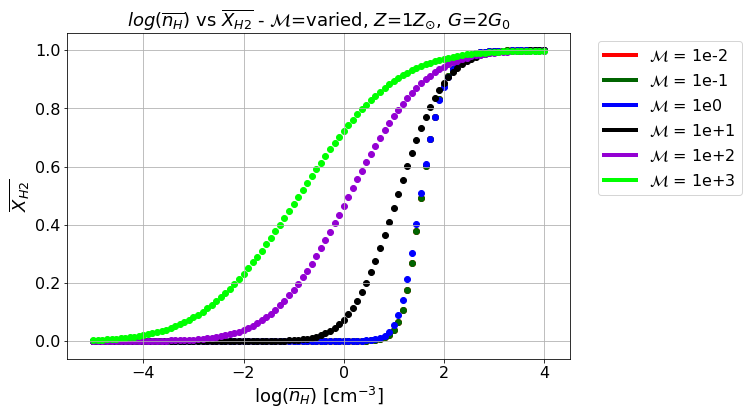

In [22]:
fig, ax = plt.subplots(figsize=(9,6))
plt.rc('figure', titlesize=18)
plt.rc('axes', titlesize=18)     # fontsize of the axes title
plt.rc('axes', labelsize=18)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=16)    # fontsize of the tick labels
plt.rc('ytick', labelsize=16)    # fontsize of the tick labels
plt.rc('legend', fontsize=16)    # legend fontsize
# plt.style.use("fivethirtyeight")
Z = 0.02/0.02
G_o = 2
label = "$\mathcal{M}$ "
color_arr = ['red','darkgreen','blue','black','darkviolet','lime']
custom_lines = [Line2D([0], [0], color='red', lw=4),
                Line2D([0], [0], color='darkgreen', lw=4),
                Line2D([0], [0], color='blue', lw=4),
                Line2D([0], [0], color='black', lw=4),
                Line2D([0], [0], color='darkviolet', lw=4),
                Line2D([0], [0], color='lime', lw=4)]
#mach_no_arr = mach_no_sim
#n_H_mean_arr = n_H_mean_sim
mach_no_arr = pynbody.array.SimArray(np.logspace(-2, 3, 6), '1')
n_H_mean_arr = pynbody.array.SimArray(np.logspace(-5, 4, 100), "cm**-3")
X_H2_bar = np.zeros(len(n_H_mean_arr))
X_CO_bar = np.zeros(len(n_H_mean_arr))
min_n_H = np.log10(np.min(n_H_mean_arr))
max_n_H = np.log10(np.max(n_H_mean_arr))
min_M = np.min(mach_no_arr)
max_M = np.max(mach_no_arr)
for m in range(0, len(mach_no_arr)):
    color = str(color_arr[m])
    mach_no = mach_no_arr[m]
    s = np.zeros(100)
    n_H = np.zeros(100)
    pdf = np.zeros(100)
    lambda_jeans = np.zeros(100)
    X_CO = np.zeros(100)
    n_CO = np.zeros(100)
    integral1 = 0
    integral2 = 0
    sigma_s = np.sqrt(np.log(1 + ((0.3 * mach_no)**2)))
    s_bar = -0.5*(sigma_s**2)
    smin = -7*sigma_s + s_bar
    smax = 7*sigma_s + s_bar
    ds = (smax - smin)/100
    for i in range(0, 100):
        s[i] = smin + i*ds
    pdf = make_pdf(s, s_bar, sigma_s)
    for y in range(0, len(n_H_mean_arr)):
            n_H_mean = n_H_mean_arr[y]
            X_H2_bar[y], X_CO_bar[y] = inside_loop(mach_no, n_H_mean, Z, G_o, K_b, T_mean, m_p, s, pdf, lambda_jeans, 
                                                  X_CO, n_CO, integral1, integral2, ds)
            plt.scatter(np.log10(n_H_mean), X_H2_bar[y], 
                      c=color)
ax.legend(  custom_lines,
                [   label + '= 1e-2',
                    label + '= 1e-1',
                    label + '= 1e0',
                    label + '= 1e+1',
                    label + '= 1e+2',
                    label + '= 1e+3'  ],
                bbox_to_anchor=(1.04,1), loc="upper left"
                    )
plt.xlabel(r'$\log(\overline{n_H})\ [\rm{cm^{-3}}]$')
plt.ylabel(r'$\overline{X_{H2}}$')
plt.grid(b=True, which='both', axis='both')
plt.title('$log(\overline{n_H})$ vs $\overline{X_{H2}}$ - $\mathcal{M}$=varied, $Z$=1$Z_{\odot}$, $G$=2$G_0$')
plt.savefig('outputs/for_thesis/X_H2_bar-n_H_mean_M.png', dpi=300, bbox_inches='tight')
plt.show()

In [9]:
np.logspace(-2, 3, 6)

array([1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03])

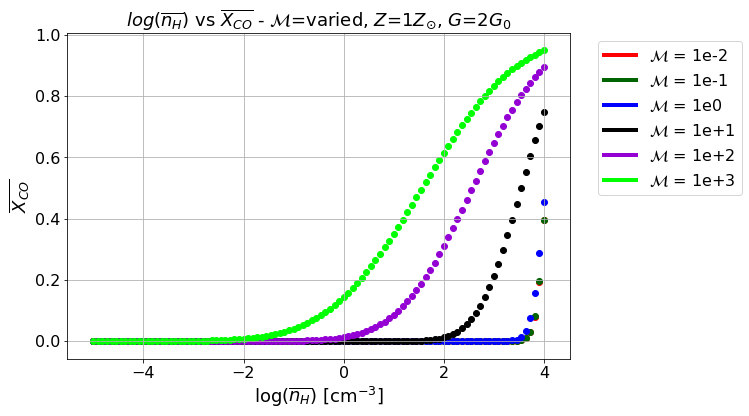

In [23]:
fig, ax = plt.subplots(figsize=(9,6))
plt.rc('figure', titlesize=18)
plt.rc('axes', titlesize=18)     # fontsize of the axes title
plt.rc('axes', labelsize=18)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=16)    # fontsize of the tick labels
plt.rc('ytick', labelsize=16)    # fontsize of the tick labels
plt.rc('legend', fontsize=16)    # legend fontsize
# plt.style.use("fivethirtyeight")
Z = 0.02/0.02
G_o = 2
label = "$\mathcal{M}$ "
color_arr = ['red','darkgreen','blue','black','darkviolet','lime']
custom_lines = [Line2D([0], [0], color='red', lw=4),
                Line2D([0], [0], color='darkgreen', lw=4),
                Line2D([0], [0], color='blue', lw=4),
                Line2D([0], [0], color='black', lw=4),
                Line2D([0], [0], color='darkviolet', lw=4),
                Line2D([0], [0], color='lime', lw=4)]
#mach_no_arr = mach_no_sim
#n_H_mean_arr = n_H_mean_sim
mach_no_arr = pynbody.array.SimArray(np.logspace(-2, 3, 6), '1')
n_H_mean_arr = pynbody.array.SimArray(np.logspace(-5, 4, 100), "cm**-3")
X_H2_bar = np.zeros(len(n_H_mean_arr))
X_CO_bar = np.zeros(len(n_H_mean_arr))
min_n_H = np.log10(np.min(n_H_mean_arr))
max_n_H = np.log10(np.max(n_H_mean_arr))
min_M = np.min(mach_no_arr)
max_M = np.max(mach_no_arr)
for m in range(0, len(mach_no_arr)):
    color = str(color_arr[m])
    mach_no = mach_no_arr[m]
    s = np.zeros(100)
    n_H = np.zeros(100)
    pdf = np.zeros(100)
    lambda_jeans = np.zeros(100)
    X_CO = np.zeros(100)
    n_CO = np.zeros(100)
    integral1 = 0
    integral2 = 0
    sigma_s = np.sqrt(np.log(1 + ((0.3 * mach_no)**2)))
    s_bar = -0.5*(sigma_s**2)
    smin = -7*sigma_s + s_bar
    smax = 7*sigma_s + s_bar
    ds = (smax - smin)/100
    for i in range(0, 100):
        s[i] = smin + i*ds
    pdf = make_pdf(s, s_bar, sigma_s)
    for y in range(0, len(n_H_mean_arr)):
            n_H_mean = n_H_mean_arr[y]
            X_H2_bar[y], X_CO_bar[y] = inside_loop(mach_no, n_H_mean, Z, G_o, K_b, T_mean, m_p, s, pdf, lambda_jeans, 
                                                  X_CO, n_CO, integral1, integral2, ds)
            plt.scatter(np.log10(n_H_mean), X_CO_bar[y], 
                      c=color)
ax.legend(  custom_lines,
                [   label + '= 1e-2',
                    label + '= 1e-1',
                    label + '= 1e0',
                    label + '= 1e+1',
                    label + '= 1e+2',
                    label + '= 1e+3'  ],
                bbox_to_anchor=(1.04,1), loc="upper left"
                    )
plt.xlabel(r'$\log(\overline{n_H})\ [\rm{cm^{-3}}]$')
plt.ylabel(r'$\overline{X_{CO}}$')
plt.grid(b=True, which='both', axis='both')
plt.title('$log(\overline{n_H})$ vs $\overline{X_{CO}}$ - $\mathcal{M}$=varied, $Z$=1$Z_{\odot}$, $G$=2$G_0$')
plt.savefig('outputs/for_thesis/X_CO_bar-n_H_mean_M.png', dpi=300, bbox_inches='tight')
plt.show()

In [11]:
np.logspace(-4, -1, 6)/0.02

array([0.005     , 0.01990536, 0.07924466, 0.31547867, 1.25594322,
       5.        ])

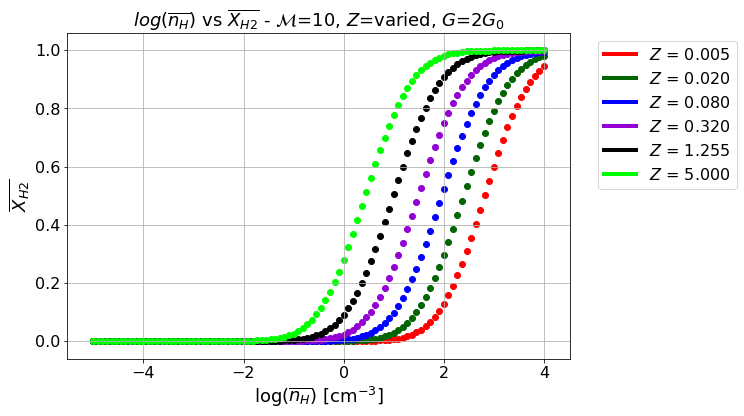

In [24]:
fig, ax = plt.subplots(figsize=(9,6))
plt.rc('figure', titlesize=18)
plt.rc('axes', titlesize=18)     # fontsize of the axes title
plt.rc('axes', labelsize=18)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=16)    # fontsize of the tick labels
plt.rc('ytick', labelsize=16)    # fontsize of the tick labels
plt.rc('legend', fontsize=16)    # legend fontsize
# plt.style.use("fivethirtyeight")
Z_arr = pynbody.array.SimArray(np.logspace(-4, -1, 6), '1')/0.02
G_o = 2
#mach_no_arr = mach_no_sim
#n_H_mean_arr = n_H_mean_sim
mach_no = 10
n_H_mean_arr = pynbody.array.SimArray(np.logspace(-5, 4, 100), "cm**-3")
X_H2_bar = np.zeros(len(n_H_mean_arr))
X_CO_bar = np.zeros(len(n_H_mean_arr))
min_n_H = np.log10(np.min(n_H_mean_arr))
max_n_H = np.log10(np.max(n_H_mean_arr))
min_Z = np.min(Z_arr)
max_Z = np.max(Z_arr)

label = "$Z$ "
color_arr = ['red','darkgreen','blue','darkviolet','black','lime']
custom_lines = [Line2D([0], [0], color='red', lw=4),
                Line2D([0], [0], color='darkgreen', lw=4),
                Line2D([0], [0], color='blue', lw=4),
                Line2D([0], [0], color='darkviolet', lw=4),
                Line2D([0], [0], color='black', lw=4),
                Line2D([0], [0], color='lime', lw=4)]
s = np.zeros(100)
n_H = np.zeros(100)
pdf = np.zeros(100)
lambda_jeans = np.zeros(100)
X_CO = np.zeros(100)
n_CO = np.zeros(100)
integral1 = 0
integral2 = 0
sigma_s = np.sqrt(np.log(1 + ((0.3 * mach_no)**2)))
s_bar = -0.5*(sigma_s**2)
smin = -7*sigma_s + s_bar
smax = 7*sigma_s + s_bar
ds = (smax - smin)/100
for i in range(0, 100):
    s[i] = smin + i*ds
pdf = make_pdf(s, s_bar, sigma_s)
for z in range(0, len(Z_arr)):
    color = str(color_arr[z])
    Z = Z_arr[z]
    for y in range(0, len(n_H_mean_arr)):
            n_H_mean = n_H_mean_arr[y]
            X_H2_bar[y], X_CO_bar[y] = inside_loop(mach_no, n_H_mean, Z, G_o, K_b, T_mean, m_p, s, pdf, lambda_jeans, 
                                                  X_CO, n_CO, integral1, integral2, ds)
            plt.scatter(np.log10(n_H_mean), X_H2_bar[y], 
                      c=color)
ax.legend(  custom_lines,
                [   label + '= 0.005',
                    label + '= 0.020',
                    label + '= 0.080',
                    label + '= 0.320',
                    label + '= 1.255',
                    label + '= 5.000'  ],
                bbox_to_anchor=(1.04,1), loc="upper left"
                    )
plt.xlabel(r'$\log(\overline{n_H})\ [\rm{cm^{-3}}]$')
plt.ylabel(r'$\overline{X_{H2}}$')
plt.grid(b=True, which='both', axis='both')
plt.title('$log(\overline{n_H})$ vs $\overline{X_{H2}}$ - $\mathcal{M}$=10, $Z$=varied, $G$=2$G_0$')
plt.savefig('outputs/for_thesis/X_H2_bar-n_H_mean_Z.png', dpi=300, bbox_inches='tight')
plt.show()

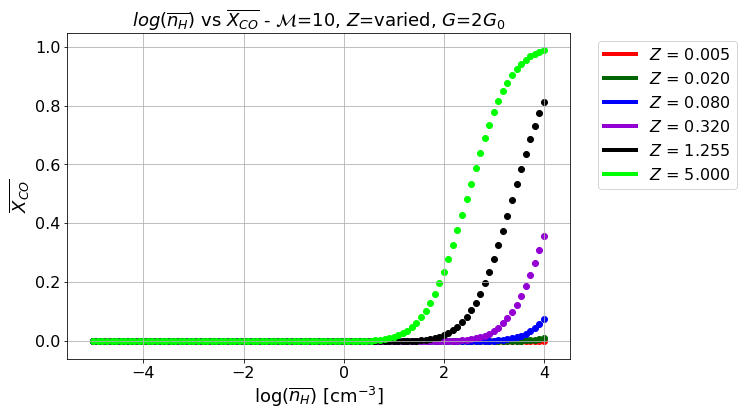

In [25]:
fig, ax = plt.subplots(figsize=(9,6))
plt.rc('figure', titlesize=18)
plt.rc('axes', titlesize=18)     # fontsize of the axes title
plt.rc('axes', labelsize=18)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=16)    # fontsize of the tick labels
plt.rc('ytick', labelsize=16)    # fontsize of the tick labels
plt.rc('legend', fontsize=16)    # legend fontsize
# plt.style.use("fivethirtyeight")
Z_arr = pynbody.array.SimArray(np.logspace(-4, -1, 6), '1')/0.02
G_o = 2
#mach_no_arr = mach_no_sim
#n_H_mean_arr = n_H_mean_sim
mach_no = 10
n_H_mean_arr = pynbody.array.SimArray(np.logspace(-5, 4, 100), "cm**-3")
X_H2_bar = np.zeros(len(n_H_mean_arr))
X_CO_bar = np.zeros(len(n_H_mean_arr))
min_n_H = np.log10(np.min(n_H_mean_arr))
max_n_H = np.log10(np.max(n_H_mean_arr))
min_Z = np.min(Z_arr)
max_Z = np.max(Z_arr)

label = "$Z$ "
color_arr = ['red','darkgreen','blue','darkviolet','black','lime']
custom_lines = [Line2D([0], [0], color='red', lw=4),
                Line2D([0], [0], color='darkgreen', lw=4),
                Line2D([0], [0], color='blue', lw=4),
                Line2D([0], [0], color='darkviolet', lw=4),
                Line2D([0], [0], color='black', lw=4),
                Line2D([0], [0], color='lime', lw=4)]
s = np.zeros(100)
n_H = np.zeros(100)
pdf = np.zeros(100)
lambda_jeans = np.zeros(100)
X_CO = np.zeros(100)
n_CO = np.zeros(100)
integral1 = 0
integral2 = 0
sigma_s = np.sqrt(np.log(1 + ((0.3 * mach_no)**2)))
s_bar = -0.5*(sigma_s**2)
smin = -7*sigma_s + s_bar
smax = 7*sigma_s + s_bar
ds = (smax - smin)/100
for i in range(0, 100):
    s[i] = smin + i*ds
pdf = make_pdf(s, s_bar, sigma_s)
for z in range(0, len(Z_arr)):
    color = str(color_arr[z])
    Z = Z_arr[z]
    for y in range(0, len(n_H_mean_arr)):
            n_H_mean = n_H_mean_arr[y]
            X_H2_bar[y], X_CO_bar[y] = inside_loop(mach_no, n_H_mean, Z, G_o, K_b, T_mean, m_p, s, pdf, lambda_jeans, 
                                                  X_CO, n_CO, integral1, integral2, ds)
            plt.scatter(np.log10(n_H_mean), X_CO_bar[y], 
                      c=color)
ax.legend(  custom_lines,
                [   label + '= 0.005',
                    label + '= 0.020',
                    label + '= 0.080',
                    label + '= 0.320',
                    label + '= 1.255',
                    label + '= 5.000'  ],
                bbox_to_anchor=(1.04,1), loc="upper left"
                    )
plt.xlabel(r'$\log(\overline{n_H})\ [\rm{cm^{-3}}]$')
plt.ylabel(r'$\overline{X_{CO}}$')
plt.grid(b=True, which='both', axis='both')
plt.title('$log(\overline{n_H})$ vs $\overline{X_{CO}}$ - $\mathcal{M}$=10, $Z$=varied, $G$=2$G_0$')
plt.savefig('outputs/for_thesis/X_CO_bar-n_H_mean_Z.png', dpi=300, bbox_inches='tight')
plt.show()

In [11]:
np.logspace(-2, 3, 6)

array([1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03])

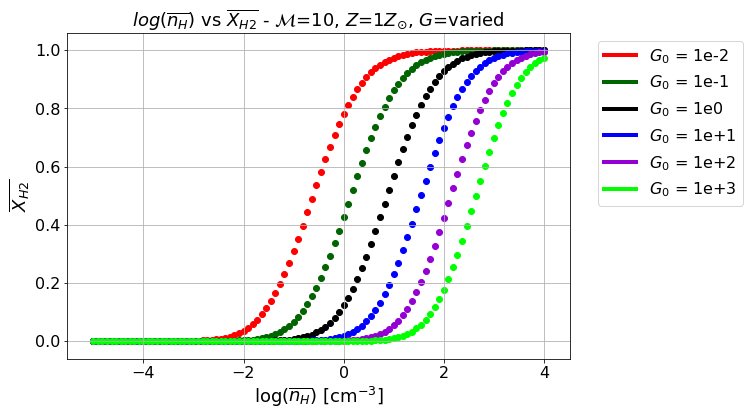

In [29]:
fig, ax = plt.subplots(figsize=(9,6))
plt.rc('figure', titlesize=18)
plt.rc('axes', titlesize=18)     # fontsize of the axes title
plt.rc('axes', labelsize=18)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=16)    # fontsize of the tick labels
plt.rc('ytick', labelsize=16)    # fontsize of the tick labels
plt.rc('legend', fontsize=16)    # legend fontsize
# plt.style.use("fivethirtyeight")
Z = 0.02/0.02
G_o_arr = pynbody.array.SimArray(np.logspace(-2, 3, 6), '1')
#mach_no_arr = mach_no_sim
#n_H_mean_arr = n_H_mean_sim
mach_no = 10
n_H_mean_arr = pynbody.array.SimArray(np.logspace(-5, 4, 100), "cm**-3")
X_H2_bar = np.zeros(len(n_H_mean_arr))
X_CO_bar = np.zeros(len(n_H_mean_arr))
min_n_H = np.log10(np.min(n_H_mean_arr))
max_n_H = np.log10(np.max(n_H_mean_arr))
min_G = np.min(G_o_arr)
max_G = np.max(G_o_arr)
label = "$G_0$ "
color_arr = ['red','darkgreen','black','blue','darkviolet','lime']
custom_lines = [Line2D([0], [0], color='red', lw=4),
                Line2D([0], [0], color='darkgreen', lw=4),
                Line2D([0], [0], color='black', lw=4),
                Line2D([0], [0], color='blue', lw=4),
                Line2D([0], [0], color='darkviolet', lw=4),
                Line2D([0], [0], color='lime', lw=4)]

s = np.zeros(100)
n_H = np.zeros(100)
pdf = np.zeros(100)
lambda_jeans = np.zeros(100)
X_CO = np.zeros(100)
n_CO = np.zeros(100)
integral1 = 0
integral2 = 0
sigma_s = np.sqrt(np.log(1 + ((0.3 * mach_no)**2)))
s_bar = -0.5*(sigma_s**2)
smin = -7*sigma_s + s_bar
smax = 7*sigma_s + s_bar
ds = (smax - smin)/100
for i in range(0, 100):
    s[i] = smin + i*ds
pdf = make_pdf(s, s_bar, sigma_s)
for g in range(0, len(G_o_arr)):
    color = str(color_arr[g])
    G_o = G_o_arr[g]
    for y in range(0, len(n_H_mean_arr)):
            n_H_mean = n_H_mean_arr[y]
            X_H2_bar[y], X_CO_bar[y] = inside_loop(mach_no, n_H_mean, Z, G_o, K_b, T_mean, m_p, s, pdf, lambda_jeans, 
                                                  X_CO, n_CO, integral1, integral2, ds)
            plt.scatter(np.log10(n_H_mean), X_H2_bar[y], 
                    c=color)
ax.legend(  custom_lines,
                [   label + '= 1e-2',
                    label + '= 1e-1',
                    label + '= 1e0',
                    label + '= 1e+1',
                    label + '= 1e+2',
                    label + '= 1e+3'  ],
                bbox_to_anchor=(1.04,1), loc="upper left"
                    )
plt.xlabel(r'$\log(\overline{n_H})\ [\rm{cm^{-3}}]$')
plt.ylabel(r'$\overline{X_{H2}}$')
plt.grid(b=True, which='both', axis='both')
plt.title('$log(\overline{n_H})$ vs $\overline{X_{H2}}$ - $\mathcal{M}$=10, $Z$=1$Z_{\odot}$, $G$=varied')
plt.savefig('outputs/for_thesis/X_H2_bar-n_H_mean_G_o.png', dpi=300, bbox_inches='tight')
plt.show()

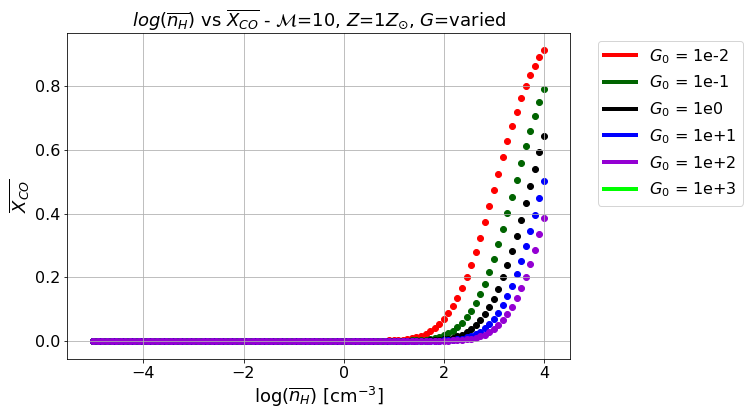

In [26]:
fig, ax = plt.subplots(figsize=(9,6))
plt.rc('figure', titlesize=18)
plt.rc('axes', titlesize=18)     # fontsize of the axes title
plt.rc('axes', labelsize=18)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=16)    # fontsize of the tick labels
plt.rc('ytick', labelsize=16)    # fontsize of the tick labels
plt.rc('legend', fontsize=16)    # legend fontsize
# plt.style.use("fivethirtyeight")
Z = 0.02/0.02
G_o_arr = pynbody.array.SimArray(np.logspace(-1, 3, 5), '1')
#mach_no_arr = mach_no_sim
#n_H_mean_arr = n_H_mean_sim
mach_no = 10
n_H_mean_arr = pynbody.array.SimArray(np.logspace(-5, 4, 100), "cm**-3")
X_H2_bar = np.zeros(len(n_H_mean_arr))
X_CO_bar = np.zeros(len(n_H_mean_arr))
min_n_H = np.log10(np.min(n_H_mean_arr))
max_n_H = np.log10(np.max(n_H_mean_arr))
min_G = np.min(G_o_arr)
max_G = np.max(G_o_arr)
label = "$G_0$ "
color_arr = ['red','darkgreen','black','blue','darkviolet','lime']
custom_lines = [Line2D([0], [0], color='red', lw=4),
                Line2D([0], [0], color='darkgreen', lw=4),
                Line2D([0], [0], color='black', lw=4),
                Line2D([0], [0], color='blue', lw=4),
                Line2D([0], [0], color='darkviolet', lw=4),
                Line2D([0], [0], color='lime', lw=4)]
s = np.zeros(100)
n_H = np.zeros(100)
pdf = np.zeros(100)
lambda_jeans = np.zeros(100)
X_CO = np.zeros(100)
n_CO = np.zeros(100)
integral1 = 0
integral2 = 0
sigma_s = np.sqrt(np.log(1 + ((0.3 * mach_no)**2)))
s_bar = -0.5*(sigma_s**2)
smin = -7*sigma_s + s_bar
smax = 7*sigma_s + s_bar
ds = (smax - smin)/100
for i in range(0, 100):
    s[i] = smin + i*ds
pdf = make_pdf(s, s_bar, sigma_s)
for g in range(0, len(G_o_arr)):
    color = str(color_arr[g])
    G_o = G_o_arr[g]
    for y in range(0, len(n_H_mean_arr)):
            n_H_mean = n_H_mean_arr[y]
            X_H2_bar[y], X_CO_bar[y] = inside_loop(mach_no, n_H_mean, Z, G_o, K_b, T_mean, m_p, s, pdf, lambda_jeans, 
                                                  X_CO, n_CO, integral1, integral2, ds)
            plt.scatter(np.log10(n_H_mean), X_CO_bar[y], 
                      c=color)
ax.legend(  custom_lines,
                [   label + '= 1e-2',
                    label + '= 1e-1',
                    label + '= 1e0',
                    label + '= 1e+1',
                    label + '= 1e+2',
                    label + '= 1e+3'  ],
                bbox_to_anchor=(1.04,1), loc="upper left"
                    )
plt.xlabel(r'$\log(\overline{n_H})\ [\rm{cm^{-3}}]$')
plt.ylabel(r'$\overline{X_{CO}}$')
plt.grid(b=True, which='both', axis='both')
plt.title('$log(\overline{n_H})$ vs $\overline{X_{CO}}$ - $\mathcal{M}$=10, $Z$=1$Z_{\odot}$, $G$=varied')
plt.savefig('outputs/for_thesis/X_CO_bar-n_H_mean_G_o.png', dpi=300, bbox_inches='tight')
plt.show()

In [14]:
np.logspace(1, 3, 4)

array([  10.        ,   46.41588834,  215.443469  , 1000.        ])

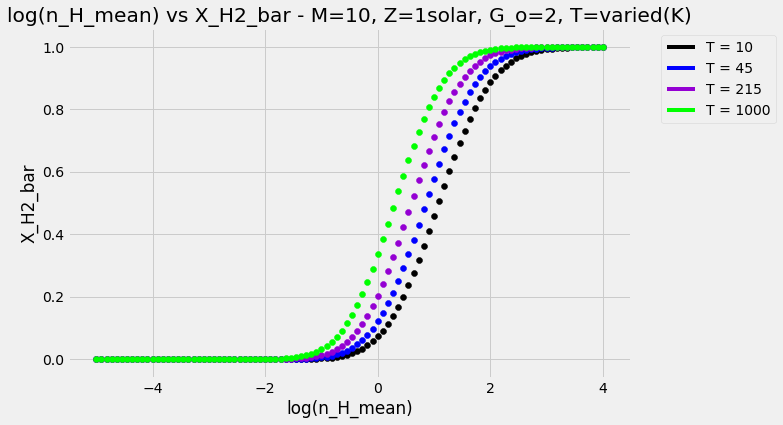

CPU times: user 13.5 s, sys: 1.56 s, total: 15.1 s
Wall time: 13.7 s


In [15]:
%%time
fig, ax = plt.subplots(figsize=(9,6))
plt.style.use("fivethirtyeight")
Z = 0.02/0.02
G_o = 2
T_arr = pynbody.array.SimArray(np.logspace(1, 3, 4), 'K')
#mach_no_arr = mach_no_sim
#n_H_mean_arr = n_H_mean_sim
mach_no = 10
n_H_mean_arr = pynbody.array.SimArray(np.logspace(-5, 4, 100), "cm**-3")
X_H2_bar = np.zeros(len(n_H_mean_arr))
X_CO_bar = np.zeros(len(n_H_mean_arr))
min_n_H = np.log10(np.min(n_H_mean_arr))
max_n_H = np.log10(np.max(n_H_mean_arr))
min_T = np.min(T_arr)
max_T = np.max(T_arr)
label = "T "
color_arr = ['black','blue','darkviolet','lime']
custom_lines = [Line2D([0], [0], color='black', lw=4),
                Line2D([0], [0], color='blue', lw=4),
                Line2D([0], [0], color='darkviolet', lw=4),
                Line2D([0], [0], color='lime', lw=4)]

s = np.zeros(100)
n_H = np.zeros(100)
pdf = np.zeros(100)
lambda_jeans = np.zeros(100)
X_CO = np.zeros(100)
n_CO = np.zeros(100)
integral1 = 0
integral2 = 0
sigma_s = np.sqrt(np.log(1 + ((0.3 * mach_no)**2)))
s_bar = -0.5*(sigma_s**2)
smin = -7*sigma_s + s_bar
smax = 7*sigma_s + s_bar
ds = (smax - smin)/100
for i in range(0, 100):
    s[i] = smin + i*ds
pdf = make_pdf(s, s_bar, sigma_s)
for t in range(0, len(T_arr)):
    color = str(color_arr[t])
    T = T_arr[t]
    for y in range(0, len(n_H_mean_arr)):
            n_H_mean = n_H_mean_arr[y]
            X_H2_bar[y], X_CO_bar[y] = inside_loop(mach_no, n_H_mean, Z, G_o, K_b, T, m_p, s, pdf, lambda_jeans, 
                                                  X_CO, n_CO, integral1, integral2, ds)
            plt.scatter(np.log10(n_H_mean), X_H2_bar[y], 
                    c=color)
ax.legend(  custom_lines,
                [   label + '= 10',
                    label + '= 45',
                    label + '= 215',
                    label + '= 1000'  ],
                bbox_to_anchor=(1.04,1), loc="upper left"
                    )
plt.xlabel('log(n_H_mean)')
plt.ylabel('X_H2_bar')
plt.grid(b=True, which='both', axis='both')
plt.title('log(n_H_mean) vs X_H2_bar - M=10, Z=1solar, G_o=2, T=varied(K)')
plt.savefig('outputs/reference_plots_1.0/X_H2_bar-n_H_mean_T.png', dpi=300, bbox_inches='tight')
plt.show()

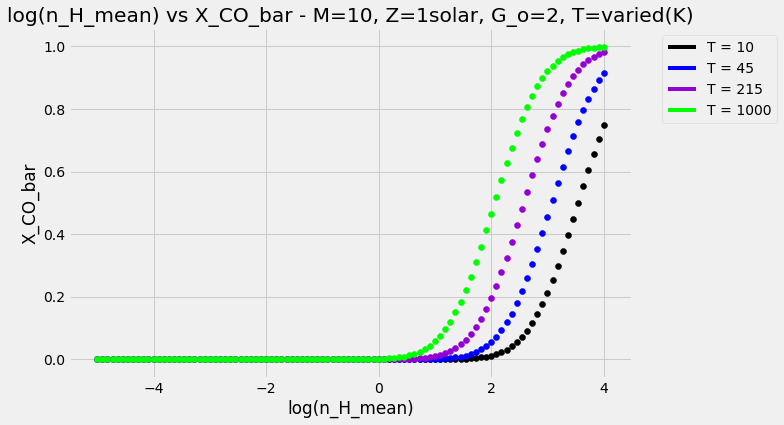

CPU times: user 14.3 s, sys: 1.54 s, total: 15.8 s
Wall time: 14.9 s


In [16]:
%%time
fig, ax = plt.subplots(figsize=(9,6))
plt.style.use("fivethirtyeight")
Z = 0.02/0.02
G_o = 2
T_arr = pynbody.array.SimArray(np.logspace(1, 3, 4), 'K')
#mach_no_arr = mach_no_sim
#n_H_mean_arr = n_H_mean_sim
mach_no = 10
n_H_mean_arr = pynbody.array.SimArray(np.logspace(-5, 4, 100), "cm**-3")
X_H2_bar = np.zeros(len(n_H_mean_arr))
X_CO_bar = np.zeros(len(n_H_mean_arr))
min_n_H = np.log10(np.min(n_H_mean_arr))
max_n_H = np.log10(np.max(n_H_mean_arr))
min_T = np.min(T_arr)
max_T = np.max(T_arr)
label = "T "
color_arr = ['black','blue','darkviolet','lime']
custom_lines = [Line2D([0], [0], color='black', lw=4),
                Line2D([0], [0], color='blue', lw=4),
                Line2D([0], [0], color='darkviolet', lw=4),
                Line2D([0], [0], color='lime', lw=4)]

s = np.zeros(100)
n_H = np.zeros(100)
pdf = np.zeros(100)
lambda_jeans = np.zeros(100)
X_CO = np.zeros(100)
n_CO = np.zeros(100)
integral1 = 0
integral2 = 0
sigma_s = np.sqrt(np.log(1 + ((0.3 * mach_no)**2)))
s_bar = -0.5*(sigma_s**2)
smin = -7*sigma_s + s_bar
smax = 7*sigma_s + s_bar
ds = (smax - smin)/100
for i in range(0, 100):
    s[i] = smin + i*ds
pdf = make_pdf(s, s_bar, sigma_s)
for t in range(0, len(T_arr)):
    color = str(color_arr[t])
    T = T_arr[t]
    for y in range(0, len(n_H_mean_arr)):
            n_H_mean = n_H_mean_arr[y]
            X_H2_bar[y], X_CO_bar[y] = inside_loop(mach_no, n_H_mean, Z, G_o, K_b, T, m_p, s, pdf, lambda_jeans, 
                                                  X_CO, n_CO, integral1, integral2, ds)
            plt.scatter(np.log10(n_H_mean), X_CO_bar[y], 
                      c=color)
ax.legend(  custom_lines,
                [   label + '= 10',
                    label + '= 45',
                    label + '= 215',
                    label + '= 1000'  ],
                bbox_to_anchor=(1.04,1), loc="upper left"
                    )
plt.xlabel('log(n_H_mean)')
plt.ylabel('X_CO_bar')
plt.grid(b=True, which='both', axis='both')
plt.title('log(n_H_mean) vs X_CO_bar - M=10, Z=1solar, G_o=2, T=varied(K)')
plt.savefig('outputs/reference_plots_1.0/X_CO_bar-n_H_mean_T.png', dpi=300, bbox_inches='tight')
plt.show()

In [15]:
%%time
def get_evolution():
    fig, ax = plt.subplots(figsize=(9,6))
    plt.rc('figure', titlesize=18)
    plt.rc('axes', titlesize=18)     # fontsize of the axes title
    plt.rc('axes', labelsize=18)    # fontsize of the x and y labels
    plt.rc('xtick', labelsize=16)    # fontsize of the tick labels
    plt.rc('ytick', labelsize=16)    # fontsize of the tick labels
    plt.rc('legend', fontsize=16)    # legend fontsize
    # plt.style.use("fivethirtyeight")
    Z = 0.02/0.02
    G_o = 2
    mach_no_arr = pynbody.array.SimArray(np.logspace(-2, 3, 6), '1')
    label = "$\mathcal{M}$ "
    color_arr = ['red','darkgreen','blue','black','darkviolet','lime']
    custom_lines = [Line2D([0], [0], color='red', lw=4),
                    Line2D([0], [0], color='darkgreen', lw=4),
                    Line2D([0], [0], color='blue', lw=4),
                    Line2D([0], [0], color='black', lw=4),
                    Line2D([0], [0], color='darkviolet', lw=4),
                    Line2D([0], [0], color='lime', lw=4)]
    for m in range(0, len(mach_no_arr)):
        mach_no = mach_no_arr[m]
        color = str(color_arr[m])
        sigma_s = np.sqrt(np.log(1 + ((0.3 * mach_no)**2)))
        s_bar = -0.5*(sigma_s**2)
        smin = -7*sigma_s + s_bar
        smax = 7*sigma_s + s_bar
        ds = (smax - smin)/1000
        n_H_mean = 1e2
        s = np.zeros(1000)
        pdf = np.zeros(1000)
        n_H = np.zeros(1000)
        for i in range(0, 1000):
            s[i] = smin + i*ds
        n_H = n_H_mean * np.exp(s)
        pdf = make_pdf(s, s_bar, sigma_s)
        plt.plot(np.log10(n_H), np.log10(pdf), color=color, lw=3)
    ax.set_ylim([-8,2.5])
    plt.xlabel(r'$\log(n_H)\ [\rm{cm^{-3}}]$')
    plt.ylabel(r'$\log(\rm{PDF})$')
    plt.grid(b=True, which='both', axis='both')
    plt.title(r'$\log(n_H)$ vs $\log(\rm{PDF})$ - $\mathcal{M}$=varied')
    ax.legend(  custom_lines,
                [   label + '= 1e-2',
                    label + '= 1e-1',
                    label + '= 1e0',
                    label + '= 1e+1',
                    label + '= 1e+2',
                    label + '= 1e+3'  ],
                bbox_to_anchor=(1.04,1), loc="upper left"
                    )
    plt.savefig('outputs/for_thesis/log(n_H)vslog(pdf)_M_evolution.png', dpi=300, bbox_inches='tight')
    #plt.show()
    return s, smin, smax, sigma_s, n_H, pdf


CPU times: user 74 µs, sys: 0 ns, total: 74 µs
Wall time: 44.8 µs


CPU times: user 1.18 s, sys: 89.4 ms, total: 1.27 s
Wall time: 1.22 s


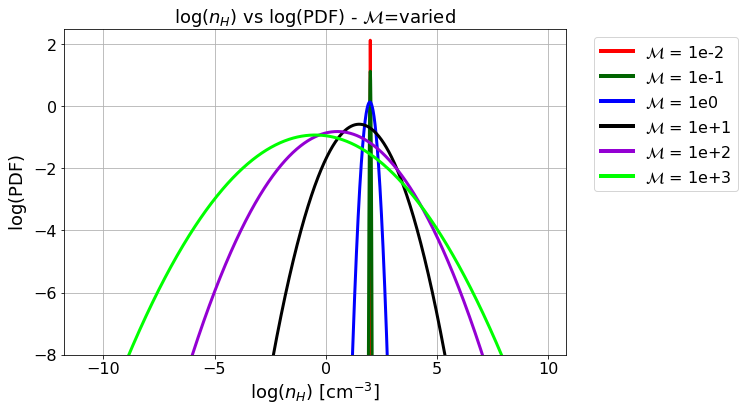

In [16]:
%%time
# order of variables:
# s, smin, smax, sigma_s, n_H, pdf
m1, m2, m3, m4, m5, m6 = get_evolution()  #varying mach_no

In [23]:
%%time
def pdf_evolution():
    fig, ax = plt.subplots(figsize=(9,6))
    plt.rc('figure', titlesize=18)
    plt.rc('axes', titlesize=18)     # fontsize of the axes title
    plt.rc('axes', labelsize=18)    # fontsize of the x and y labels
    plt.rc('xtick', labelsize=16)    # fontsize of the tick labels
    plt.rc('ytick', labelsize=16)    # fontsize of the tick labels
    plt.rc('legend', fontsize=16)    # legend fontsize
    # plt.style.use("fivethirtyeight")
    Z = 0.02/0.02
    G_o = 1
    eps = 0.16
    mach_no_arr = pynbody.array.SimArray(np.logspace(-2, 3, 6), '1')
    label = "M "
    color_arr = ['red','darkgreen','blue','black','darkviolet','lime']
    custom_lines = [Line2D([0], [0], color='red', lw=4),
                    Line2D([0], [0], color='darkgreen', lw=4),
                    Line2D([0], [0], color='blue', lw=4),
                    Line2D([0], [0], color='black', lw=4),
                    Line2D([0], [0], color='darkviolet', lw=4),
                    Line2D([0], [0], color='lime', lw=4)]
    for m in range(0, len(mach_no_arr)):
        mach_no = mach_no_arr[m]
        color = str(color_arr[m])
        sigma_s = np.sqrt(np.log(1 + ((0.3 * mach_no)**2)))
        s_bar = -0.5*(sigma_s**2)
        smin = -7*sigma_s + s_bar
        smax = 7*sigma_s + s_bar
        ds = (smax - smin)/1000
        n_H_mean = 1e2
        s = np.zeros(1000)
        pdf = np.zeros(1000)
        n_H = np.zeros(1000)
        for i in range(0, 1000):
            s[i] = smin + i*ds
        n_H = n_H_mean * np.exp(s)
        pdf = make_pdf(s, s_bar, sigma_s)
        tau = (1+(2*eps*np.exp(s))-np.sqrt(1+(4*eps*np.exp(s))))/(2*(eps**2)*np.exp(s))
        s_prime = np.log(tau)
        q = ((1-(eps*np.exp(s_prime)))**3)/(1+(eps*np.exp(s_prime)))
        pdf_prime = make_pdf(s_prime, s_bar, sigma_s) * q
        norm = np.sum(np.exp(s)*pdf_prime*ds)
        pdf_prime = pdf_prime/norm
        plt.plot(np.log10(n_H), np.log10(pdf_prime), color=color, lw=4)
    plt.xlabel('$log(n_H)\ [cm^{-3}]$')
    plt.ylabel('$log(PDF)$ (power-law PDF)')
    plt.grid(b=True, which='both', axis='both')
    plt.title('$log(n_H)$ vs $log(PDF)$ - power-law PDF & $\mathcal{M}$=varied')
    ax.legend(  custom_lines,
                [   label + '= 1e-2',
                    label + '= 1e-1',
                    label + '= 1e0',
                    label + '= 1e+1',
                    label + '= 1e+2',
                    label + '= 1e+3'  ],
                bbox_to_anchor=(1.04,1), loc="upper left"
                    )
    plt.savefig('outputs/reference_plots_1.0/log(n_H)vslog(pdf)-pdf evolution.png', 
                dpi=300, bbox_inches='tight')
    #plt.show()
    return s, smin, smax, sigma_s, n_H, pdf, pdf_prime


CPU times: user 45 µs, sys: 0 ns, total: 45 µs
Wall time: 31 µs


/net/cephfs/home/mkrets/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in divide
/net/cephfs/home/mkrets/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: divide by zero encountered in log
/net/cephfs/home/mkrets/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:44: RuntimeWarning: divide by zero encountered in log10


CPU times: user 1.09 s, sys: 40.7 ms, total: 1.13 s
Wall time: 1.12 s


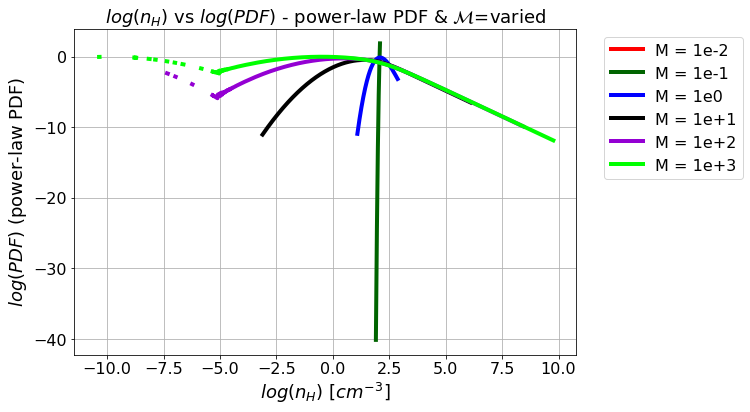

In [24]:
%%time
# order of variables:
# s, smin, smax, sigma_s, n_H, pdf, pdf_prime
p1, p2, p3, p4, p5, p6, p7 = pdf_evolution()  #varying mach_no